In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Step 2: Preprocess the dataset (directly without graph conversion)
def preprocess(df):
    # Encode categorical columns
    df = df_label_encoder(df, ['type', 'nameOrig', 'nameDest'])

    # Normalize numeric columns
    df['amount'] = (df['amount'] - df['amount'].min()) / (df['amount'].max() - df['amount'].min())
    df['oldbalanceOrg'] = (df['oldbalanceOrg'] - df['oldbalanceOrg'].min()) / (df['oldbalanceOrg'].max() - df['oldbalanceOrg'].min())
    df['newbalanceOrig'] = (df['newbalanceOrig'] - df['newbalanceOrig'].min()) / (df['newbalanceOrig'].max() - df['newbalanceOrig'].min())
    df['oldbalanceDest'] = (df['oldbalanceDest'] - df['oldbalanceDest'].min()) / (df['oldbalanceDest'].max() - df['oldbalanceDest'].min())
    df['newbalanceDest'] = (df['newbalanceDest'] - df['newbalanceDest'].min()) / (df['newbalanceDest'].max() - df['newbalanceDest'].min())

    # Extract features
    features = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type']].values

    # Labels (0 for non-fraud, 1 for fraud)
    labels = df['isFraud'].values

    return torch.tensor(features, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

In [4]:
# Load dataset and preprocess
df = pd.read_csv('paysim/paysim.csv')  # Update with your .csv file path
features, labels = preprocess(df)

In [5]:
# Function to plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

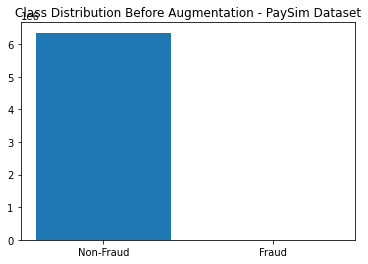

In [6]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation - PaySim Dataset")

In [7]:
# Define GAN components
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(z))

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [9]:
# GAN parameters
input_size = features.shape[1]  # Number of features
hidden_size = 128
output_size = input_size  # Output size matches input for features
latent_size = 64

In [10]:
# Initialize GAN components
generator = Generator(latent_size, hidden_size, output_size)
discriminator = Discriminator(input_size, hidden_size)

In [11]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [12]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [13]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([0.0019, 0.0140, 0.0172, 0.0031, 0.0034, 1.7141]), Initial Variance: tensor([4.2668e-05, 2.3496e-03, 3.4775e-03, 9.1161e-05, 1.0641e-04, 1.8228e+00]), Initial Std Dev: tensor([0.0065, 0.0485, 0.0590, 0.0095, 0.0103, 1.3501])


In [14]:
num_epochs = 10
target_minority_class = torch.sum(labels == 0)  # We want to match the majority class count
real_data = features[labels == 1]  # Fraud samples (minority class)

In [15]:
def compute_r_squared(real_data, generated_data):
    real_mean = torch.mean(real_data, dim=0)

    # Sum of squared residuals (SSR)
    ssr = torch.sum((real_data - generated_data) ** 2)

    # Total sum of squares (SST)
    sst = torch.sum((real_data - real_mean) ** 2)

    # R² calculation
    r_squared = 1 - (ssr / sst)
    return r_squared.item()

In [16]:
for epoch in range(num_epochs):
    # Update current minority count during each epoch to reflect balancing progress
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break  # Stop training when the minority class is balanced

    # Sample noise for generator input
    z = torch.randn(real_data.size(0), latent_size)

    # Generate fake data
    fake_data = generator(z)

    # Train Discriminator
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data.detach())
    loss_d = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    # Train Generator
    d_fake = discriminator(fake_data)
    loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Calculate R² for real and generated data
    r_squared = compute_r_squared(real_data, fake_data)
    
    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}, R²: {r_squared}')

    # Update labels and features based on newly generated samples (for example, appending new data)
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    features = torch.cat((features, fake_data))

Epoch [0/10], Loss D: 1.3347734212875366, Loss G: 0.6180769205093384, R²: -2.316431999206543
Epoch [1/10], Loss D: 1.3209400177001953, Loss G: 0.6198679804801941, R²: -2.294131278991699
Epoch [2/10], Loss D: 1.3076952695846558, Loss G: 0.6218376159667969, R²: -2.2741758823394775
Epoch [3/10], Loss D: 1.2949329614639282, Loss G: 0.6239277124404907, R²: -2.252680778503418
Epoch [4/10], Loss D: 1.2828624248504639, Loss G: 0.6259090304374695, R²: -2.236121892929077
Epoch [5/10], Loss D: 1.2711207866668701, Loss G: 0.6280781626701355, R²: -2.2191410064697266
Epoch [6/10], Loss D: 1.2599047422409058, Loss G: 0.6302530169487, R²: -2.2000796794891357
Epoch [7/10], Loss D: 1.24924898147583, Loss G: 0.6323675513267517, R²: -2.179013252258301
Epoch [8/10], Loss D: 1.2389155626296997, Loss G: 0.6346189379692078, R²: -2.1609833240509033
Epoch [9/10], Loss D: 1.229106068611145, Loss G: 0.636805534362793, R²: -2.141470432281494


In [17]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))  # Generate samples
y_generated = torch.ones(num_generated_samples, dtype=torch.long)  # Label these as fraudulent (minority class)

In [18]:
# Combine generated data with the original data
x_augmented = torch.cat([features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

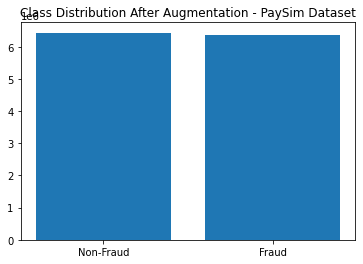

In [19]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation - PaySim Dataset")

In [20]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

Final Mean: tensor([0.2933, 0.1987, 0.1948, 0.2821, 0.2053, 1.1365],
       grad_fn=<MeanBackward1>), Final Variance: tensor([0.0850, 0.0362, 0.0341, 0.0785, 0.0416, 1.2380],
       grad_fn=<VarBackward0>), Final Std Dev: tensor([0.2916, 0.1902, 0.1846, 0.2803, 0.2040, 1.1127],
       grad_fn=<StdBackward0>)


In [21]:
final_r_squared = compute_r_squared(real_data, fake_data)
print(f'Final R² between real and generated fraud samples: {final_r_squared}')

Final R² between real and generated fraud samples: -2.141470432281494
